In [57]:
#external libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point,Polygon
import matplotlib.pyplot as plt
import folium
from folium.plugins import TimestampedGeoJson
from datetime import datetime

import matplotlib as mpl
import matplotlib.colors as mcolors

%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
#local imports
from func.DataLoader import gdfLoader,ReadMarkerMap,RSSIDataLoader
from func.utils.getMarkerDictList import getMarkerDictList
from func.FoliumFeatureCreation.RawDataFeatures import RawDataFeatures

In [59]:
MapDataPath="data/cartePalaiseau.csv"
ModuleMapPath="data/carteModulePalaiseau.csv"

Datapaths=['data/manip3/664E.csv','data/manip3/104D.csv','data/manip3/3480.csv']
colors=["red","blue","green"]

saving_output=False
rolling_mean=10#rolling mean for rssi values in seconds
sampling_time=2000#ms #si supérieur à 2000ms il faut implémenter la moyenne dans la liste des rssi dans marker dict list

### Data loading


In [60]:
#Map Data
map_gdf=gdfLoader(MapDataPath)
map_gdf.to_crs(epsg=4326, inplace=True)
#marker data
marker_gdf=ReadMarkerMap(ModuleMapPath)
#rssi data
raw_rssi_df=[]
for path in Datapaths:
    raw_rssi_df.append(RSSIDataLoader(path))


In [61]:
#to optimize the getting of location of macModule, we create a dictionnary
MacModuleLocation = marker_gdf.set_index("macModule").to_dict()["geometry"]

### Bind the received RSSI Data to the CartoModule Marker on Map

In [62]:
#create a list of timestamps between min_timestamp and max_timestamp with a step of sampling_time
min_timestamp=raw_rssi_df[0].iloc[0]['timestamp']+pd.Timedelta(sampling_time, unit="ms")
max_timestamp=raw_rssi_df[0].iloc[-1]['timestamp']
timestamp_list= pd.date_range(start=min_timestamp, end=max_timestamp, freq=str(sampling_time)+"ms").tolist()


In [63]:
marker_dict_list_list=[]
for raw_rssi_df_i in raw_rssi_df:
    marker_dict_list_list.append(getMarkerDictList(raw_rssi_df_i, timestamp_list))

colormap creation

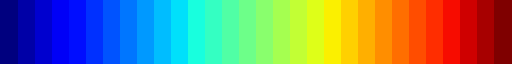

In [64]:
cmap = mpl.colormaps['jet'].resampled(30)
cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, 30)))
cmap

In [65]:
##moving average
rssi_df_list=[]
for markerdictlist in marker_dict_list_list:
    #create the dataframe with the timestamp
    rssi_df = pd.DataFrame({'timestamp': pd.to_datetime(timestamp_list)})

    #set timestamp as index ?
    rssi_df.set_index('timestamp', inplace=True)

    #fill the dataframe with NaN
    for i in MacModuleLocation.keys():
        rssi_df[i]=np.nan
    #fill the dataframe with the rssi value from the MarkerDictList
    for i in range(len(markerdictlist)):
        for key in markerdictlist[i]:
            rssi_df.loc[timestamp_list[i],key]=markerdictlist[i][key]
    #apply the rolling mean on each column
    rssi_df=rssi_df.rolling(str(rolling_mean)+"s").mean()
    rssi_df_list.append(rssi_df)

In [66]:

def getFeatureList(rssi_df,MacModuleLocation):
    input_format = '%Y-%m-%d %H:%M:%S.%f'
    output_format = '%Y-%m-%dT%H:%M:%S'
    pointList=[]
    MarkerTimestamplist=[]
    rssiList=[]
    #iterate through rssidf to fill PointList,MarkerTimestamplist,rssiList
    for index,timestamp in enumerate(rssi_df.index):
        dt = datetime.strptime(str(timestamp), input_format)
        new_timestamp = dt.strftime(output_format)
        for macModule in MacModuleLocation.keys():
            if not np.isnan(rssi_df.iloc[index][macModule]):
                point=MacModuleLocation[macModule]
                pointList.append([point.x,point.y])
                MarkerTimestamplist.append(new_timestamp)
                rssiList.append(rssi_df.iloc[index][macModule])
                
    return pointList,MarkerTimestamplist,rssiList


def CreateUnicolorFeatures(pointList,rssiList,MarkerTimestamplist,color):
    features = []
    for index in range(len(pointList)):
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': pointList[index]
            },
            'properties': {
                'times': [MarkerTimestamplist[index]],
                "icon": 'circle',
                "popup": str(rssiList[index]),
                "iconstyle": {
                    "color": color,
                    "fillOpacity": "0",  
                    "radius": str(int(1*(80+rssiList[index])))  #radius must be an integer    
                }}
            }
        features.append(feature)
    return features


In [69]:
feature_list=[]
for index,rssi_df in enumerate(rssi_df_list):
    for index,rssi_df in enumerate(rssi_df_list):
        pointList,MarkerTimestamplist,rssiList=getFeatureList(rssi_df,MacModuleLocation) 
        rolled_data_features=CreateUnicolorFeatures(pointList,rssiList,MarkerTimestamplist,color=colors[index])
        for feature in rolled_data_features:
            feature_list.append(feature)
    
MarkerLayer=TimestampedGeoJson(
                {"type": "FeatureCollection","features": feature_list},
                period='PT2S',
                duration='PT1S',
                transition_time=sampling_time,
                auto_play=True)


In [70]:
m = folium.Map(location = [48.713166904690254, 2.2007200581389768],max_zoom=30, zoom_start=20,crs="EPSG3857")
tooltip = folium.features.GeoJsonTooltip(fields=['ID_element', 'nom'], 
                                        labels=True,
                                        stick=False)
folium.GeoJson(map_gdf, tooltip=tooltip).add_to(m)
MarkerLayer.add_to(m)
folium.LayerControl().add_to(m)
if saving_output:
    m.save('output/rolled_marker_map.html')
m